In [88]:
from pycaret.regression import *
import pandas as pd
import matplotlib.pyplot as plt
from functions import accuracy
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [89]:
df_raw = pd.read_csv('kastom_filled.csv', parse_dates=[0], index_col=0)
df=df_raw.asfreq('H', method='pad')[:-512]
df

,Temp (C),Humidity (%),PM10 (ug/m3),PM2.5 (ug/m3),PM1 (ug/m3),NO2 (ppb),CO (μg/m3 10²)
2022-04-10 00:00:00,18.32,58.78,39.0,23.0,10.0,61.64,92.88
2022-04-10 01:00:00,16.80,60.04,33.5,20.0,9.0,58.22,49.21
2022-04-10 02:00:00,16.10,58.67,22.0,13.0,5.0,58.22,37.32
2022-04-10 03:00:00,16.63,56.95,30.5,19.0,8.0,61.64,48.01
2022-04-10 04:00:00,17.07,54.34,29.0,18.0,7.0,58.22,46.49
...,...,...,...,...,...,...,...
2022-09-04 19:00:00,26.98,84.32,185.5,229.0,271.5,65.07,37.90
2022-09-04 20:00:00,27.02,84.70,186.0,229.0,272.0,58.22,34.60
2022-09-04 21:00:00,25.85,95.16,186.0,229.0,271.5,71.92,36.27
2022-09-04 22:00:00,24.02,100.00,182.0,226.0,270.0,68.49,40.57


In [90]:
target = 'CO (μg/m3 10²)'
ignore_list = ['PM1 (ug/m3)', 'PM10 (ug/m3)'] if target=='PM2.5 (ug/m3)' else []

steps = int(df.shape[0]*0.25)
train = df[:-steps]
test = df[-steps:-steps+(24*7)]

numeric_features = df.columns.drop(target).to_list()

In [91]:
s = setup(data=train, test_data=test, target=target, fold_strategy='timeseries',
          numeric_features=numeric_features, ignore_features=ignore_list,
          fold=10,silent=True, session_id=123, verbose=0)

### Training and Validation of various models

In [92]:
#comparison = compare_models()

### Επιλογή Random Forest (αποδεκτές επιδόσεις, δοκιμασμένος στη βιβλιογραφία)

In [93]:
model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.9040,264.7787,16.2720,-0.1693,0.3327,0.3203
1,9.6516,163.0240,12.7681,0.3325,0.2724,0.2440
2,9.4441,167.9934,12.9612,0.4630,0.2455,0.1989
3,11.8699,240.5915,15.5110,0.2322,0.2771,0.2395
4,10.1310,183.9750,13.5637,0.3476,0.3570,0.5921
5,10.5047,220.5788,14.8519,0.4379,0.3090,0.2798
6,10.0634,168.4835,12.9801,0.3768,0.2691,0.2432
7,7.5399,95.3677,9.7656,0.5668,0.2655,0.2407
8,9.6781,135.9912,11.6615,0.4393,0.3574,0.3707


### Πρόβλεψη NO2

In [94]:
predictions = predict_model(model, data=test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8.1977,103.2048,10.1590,0.3888,0.2876,0.2703


In [95]:
errors_list = [mean_absolute_error(predictions[target], predictions.Label),
               mean_squared_error(predictions[target], predictions.Label),
              accuracy(predictions[target], predictions.Label)['mape'],
              r2_score(predictions[target], predictions.Label)]

errors_series = pd.Series(errors_list, index=['MAE','MSE','MAPE','R2'])
target_name = 'PM2.5' if target=='PM2.5 (ug/m3)' else 'CO' if target=='CO (μg/m3 10²)' else target
errors_series.to_csv(f'{target_name}_rf_metrics.csv')
print(errors_series.round(3))

MAE       8.198
MSE     103.205
MAPE      0.202
R2        0.389
dtype: float64


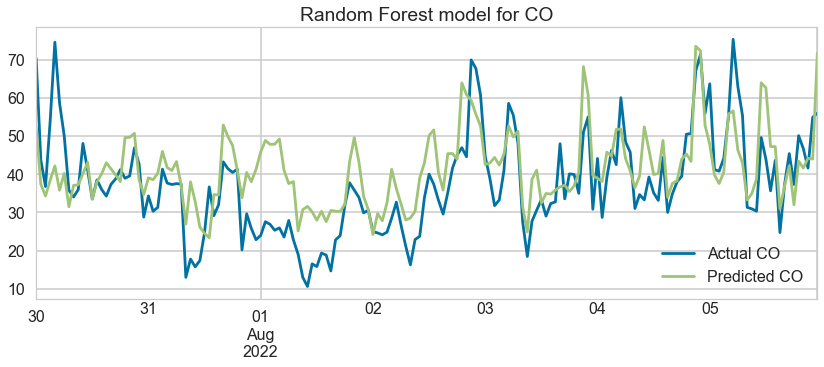

In [96]:
plt.style.use('seaborn-poster')
predictions[[target, 'Label']].plot(figsize=(14,5))
plt.legend([f'Actual {target_name}', f'Predicted {target_name}'])
plt.title(f"Random Forest model for {target_name}")
plt.savefig(f"Plots/rf/{target_name}rf.png")
plt.show()

#### Να το κάνω και στα υπόλοιπα test = df[-steps:-steps+(24*7)]

In [97]:
plot_model(model, plot='feature', save=True)

'Feature Importance.png'

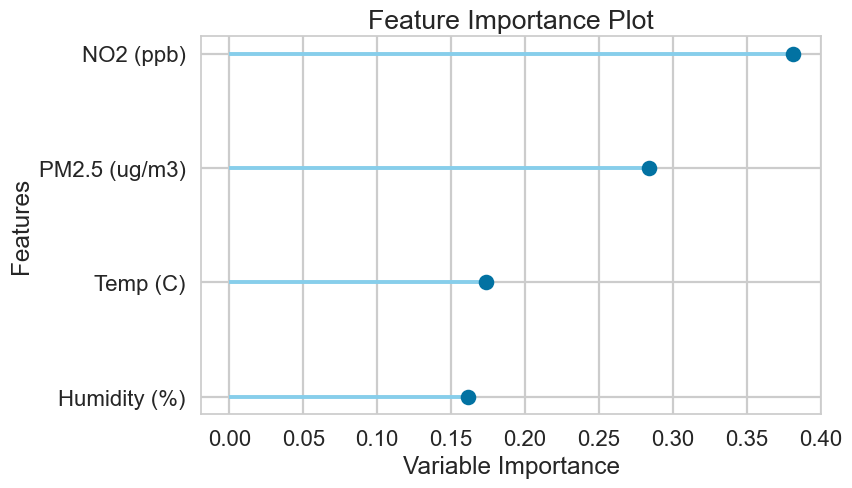

In [98]:
plot_model(model, plot='feature')